In [193]:
import glob
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

In [194]:
folders = glob.glob('*')
# folders = [folder for folder in folders if os.path.isdir(folder) and ('clemens' in folder or 'sas' in folder)]
folders = [folder for folder in folders if os.path.isdir(folder) and ('DeepCubeA' not in folder)]

results = {}

for key in folders:
    results[key] = {folder.split('/')[-1]: {'expanded': [10**9 for i in range(200)], 'evaluated': [10**9 for i in range(200)], 'memory': [10**7 for i in range(200)], 'time': [10**4 for i in range(200)], 'plan_status': [0 for i in range(200)]} for folder in glob.glob(key + '/*') if not ('max' in folder and '-' not in folder)}

In [195]:
results.keys()

dict_keys(['clemens_results_18', 'sas_results', 'test_results_12', 'clemens_results_12', 'test_results_18'])

In [196]:
def extract_params_failed(file):
    
    with open(file, 'r') as f:
        content = f.readlines()
    
    last_states_line = 0
    flag1 = 0
    flag2 = 0
    for idx in range(len(content)):
        if 'evaluated' in content[idx]:
            last_states_line = idx
        
        if 'Peak memory:' in content[idx]:
            memory = int(content[idx].split('Peak memory:')[-1].split('KB')[0].strip())
            flag2 = 1

        if 'caught signal' in content[idx]:
            total_time = float(10**4) 
            flag1 = 1
        elif 'Planner time:' in content[idx]:
            total_time = float(content[idx].split('Planner time:')[-1].split('s')[0].strip())
            flag1 = 1
    
    if flag1 == 0:
        total_time = float(10**4)
    if flag2 == 0:
        memory = int(10**7)

    
    for item in content[last_states_line].split(','):
        if 'expanded' in item:
            expanded_last_states = int(item.split('expanded')[0].strip())
        if 'evaluated' in item:
            evaluated_last_states = int(item.split('evaluated')[0].strip())
        
    return expanded_last_states, evaluated_last_states, total_time, memory


def extract_params(file):
    
    with open(file, 'r') as f:
        content = f.readlines()
        
    for line in content:
        # print(line)
        if 'Expanded until last jump:' in line:
            expanded_last_states =  int(line.split('Expanded until last jump:')[-1].split('state')[0].strip())
        if 'Generated until last jump:' in line:
            generated_last_states =  int(line.split('Generated until last jump:')[-1].split('state')[0].strip())
        if 'Evaluated until last jump:' in line:
            evaluated_last_states =  int(line.split('Evaluated until last jump:')[-1].split('state')[0].strip())
       
        if 'Expanded' in line and 'until last jump' not in line and 'state' in line:
            expanded_states = int(line.split('Expanded')[-1].split('state')[0].strip())
        if 'Generated' in line and 'until last jump' not in line and 'state' in line:
            generated_states = int(line.split('Generated')[-1].split('state')[0].strip())
        if 'Evaluated' in line and 'until last jump' not in line and 'state' in line:
            evaluated_states = int(line.split('Evaluated')[-1].split('state')[0].strip())
            
        if 'Search time:' in line:
            search_time = float(line.split('Search time:')[-1].split('s')[0].strip())
        if 'Planner time:' in line:
            total_time = float(line.split('Planner time:')[-1].split('s')[0].strip())
        if 'Peak memory:' in line:
            memory = int(line.split('Peak memory:')[-1].split('KB')[0].strip())
    
    return expanded_states, generated_states, evaluated_states, expanded_last_states, generated_last_states, evaluated_last_states, search_time, total_time, memory

In [197]:
for folder in folders:
    folder_name = folder.split('/')[-1]
    
    if folder_name not in results.keys():
        continue
    
    for subfolder in glob.glob(folder + '/*'):
        subfolder_name = subfolder.split('/')[-1]
        
        if subfolder_name not in results[folder_name].keys():
            continue
        
        if len(glob.glob(subfolder + '/output*')) < 200:
            continue

        for output_file in glob.glob(subfolder + '/output*'):
            # print(output_file)
            output_name = output_file.split('/')[-1]
            pattern = r'\d+'
            numbers = re.findall(pattern, output_name)

            if 'test_results' not in folder_name:
                idx = (int(numbers[0]) - 1)*10 + int(numbers[1])
            else:
                idx = (int(numbers[0]) - 1)*10 + int(numbers[1]) - 1
                
            if 'Solution found.' in open(output_file, 'r').read():
                expanded_states, generated_states, evaluated_states, expanded_last_states, generated_last_states, evaluated_last_states, search_time, total_time, memory = extract_params(output_file)
                results[folder_name][subfolder_name]['expanded'][idx] = expanded_states
                results[folder_name][subfolder_name]['evaluated'][idx] = evaluated_states
                results[folder_name][subfolder_name]['memory'][idx] = memory
                results[folder_name][subfolder_name]['time'][idx] = total_time
                plan_file = output_file.replace('output', 'plan')
                if os.path.exists(plan_file):
                    results[folder_name][subfolder_name]['plan_status'][idx] = 1
                else:
                    results[folder_name][subfolder_name]['plan_status'][idx] = 2
            else:
                expanded_states, evaluated_states, total_time, memory = extract_params_failed(output_file)
                results[folder_name][subfolder_name]['expanded'][idx] = expanded_states
                results[folder_name][subfolder_name]['evaluated'][idx] = evaluated_states
                results[folder_name][subfolder_name]['memory'][idx] = memory
                results[folder_name][subfolder_name]['time'][idx] = total_time
                results[folder_name][subfolder_name]['plan_status'][idx] = 0
            

In [198]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator

warnings.filterwarnings('ignore', category=UserWarning)

sns.set_style('whitegrid')
sns.set_palette('Greys')
# sns.set()

In [199]:
plot_setting = {
    "blind": {"color": "#FF0000", "marker": "x", "size": 40, "edgecolor": "white", "linewidth": 1},
    "merge-and-shrink": {"color": "#3988f7", "marker": "s", "size": 30, "edgecolor": "white", "linewidth": 0.4},
    "max-systematic-pdb": {"color": "#6aa86a", "marker": "^", "size": 20, "edgecolor": "white" , "linewidth": 0.4},
    "context_enhanced_additive": {"color": "#FFA500", "marker": "o", "size": 30, "edgecolor": "white", "linewidth": 0.4},
    "max-manual-pdb": {"color": "#800080", "marker": "p", "size": 30, "edgecolor": "white", "linewidth": 0.4},
    "goal_count": {"color": "#c7e327", "marker": "*", "size": 50, "edgecolor": "black", "linewidth": 0.4},
    "max": {"color": "#FF69B4", "marker": "v", "size": 40, "edgecolor": "white", "linewidth": 0.4},
    "lm_cost": {"color": "#588ab0", "marker": "X", "size": 40, "edgecolor": "white", "linewidth": 0.6},
    "ff": {"color": "#458c8f", "marker": "d", "size": 30, "edgecolor": "white", "linewidth": 0.4},
    "causal_graph": {"color": "#cf047a", "marker": "+", "size": 50, "edgecolor": "white", "linewidth": 0.4},
}

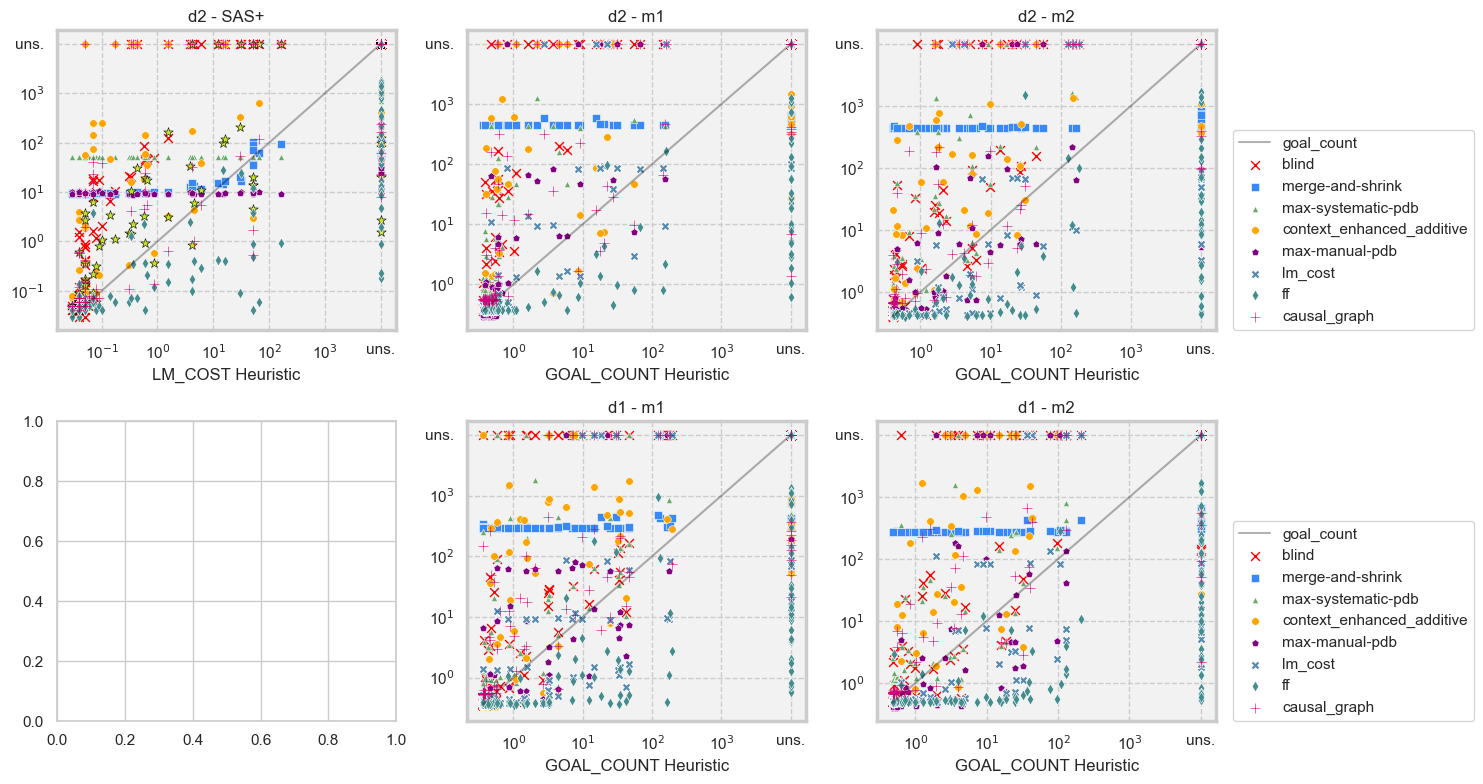

In [209]:
# heuristic_list = [item for item in results['clemens_results_18'].keys() if item not in ['merge-and-shrink', 'max-systematic-pdb', 'max-manual-pdb']]
# x_key = 'ff'

# heuristic_list = [item for item in results['clemens_results_18'].keys() if item in ['merge-and-shrink', 'max-systematic-pdb', 'max-manual-pdb']]
# x_key = 'max-manual-pdb'

heuristic_list = [item for item in results['clemens_results_18'].keys() ]
x_key = 'goal_count'


def format_ticks(value, tick_number):
    if value == 1e4:
        return "uns."
    else:
        exponent = int(round(np.log10(value)))
        return "10$^{%d}$" % exponent

fig, axs = plt.subplots(2, 3, figsize=(15,8))

plot_dict = {
    'clemens_results_12': [0,1],
    'clemens_results_18': [0,2],
    'test_results_12': [1,1],
    'test_results_18': [1,2],
    'sas_results': [0,0]
}

for i, key in enumerate(results.keys()):

    # if 'sas' in key:
    #     continue
    # if 'test' in key:
    #     continue

    if 'sas' in key:
        x_key = 'lm_cost'
    else:
        x_key = 'goal_count'

    df_evaluated = pd.DataFrame(columns=heuristic_list)
    for sub_key in results[key].keys():
        if sub_key not in heuristic_list:
            continue
        temp_evaluated = results[key][sub_key]['time']
        plan_status_list = results[key][sub_key]['plan_status']

        count = 0
        for ind in range(len(temp_evaluated)):
            if plan_status_list[ind] != 1:
                temp_evaluated[ind] = 10**4
            else:
                count += 1
        
        # print(key, sub_key, count)

        df_evaluated[sub_key] = [item for item in temp_evaluated]

    ax = axs[plot_dict[key][0], plot_dict[key][1]]

    sns.lineplot(x=x_key, y=x_key, data=df_evaluated , color= 'black', ax=ax, alpha=0.3, label=x_key)
    for column in df_evaluated.columns:
        if column != x_key:
            sns.scatterplot(x=x_key, y=column, data=df_evaluated, label=column, color=plot_setting[column]['color'], marker=plot_setting[column]['marker'], ax=ax, s=plot_setting[column]['size'], edgecolor=plot_setting[column]['edgecolor'], linewidth=plot_setting[column]['linewidth'])

    ax.legend().remove()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('')
    ax.set_xlabel(x_key.upper() + ' Heuristic')
    if '12' in key:
        if 'test' in key:
            ax.set_title('d1 - m1')
        else:
            ax.set_title('d2 - m1')
    elif '18' in key:
        if 'test' in key:
            ax.set_title('d1 - m2')
            ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
        else:
            ax.set_title('d2 - m2')
            ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    else:
        ax.set_title('d2 - SAS+')
    
    formatter = FuncFormatter(format_ticks)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    for spine in ax.spines.values():
        spine.set_linewidth(2.5)

    ax.grid(False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, linestyle='--', linewidth=1)
    ax.xaxis.grid(True, linestyle='--', linewidth=1)

    ax.set_facecolor('#f2f2f2')

plt.tight_layout()
plt.show()


In [215]:
# heuristic_list = [item for item in results['clemens_results_18'].keys() if item not in ['merge-and-shrink', 'max-systematic-pdb', 'max-manual-pdb']]
# x_key = 'ff'

# heuristic_list = [item for item in results['clemens_results_18'].keys() if item in ['merge-and-shrink', 'max-systematic-pdb', 'max-manual-pdb']]
# x_key = 'max-manual-pdb'

heuristic_list = [item for item in results['clemens_results_18'].keys() ]
# x_key = 'goal_count'

for heuristic in heuristic_list:
    x_key = heuristic
    def format_ticks(value, tick_number):
        if value == 1e9:
            return "uns."
        else:
            exponent = int(round(np.log10(value)))
            return "10$^{%d}$" % exponent

    fig, axs = plt.subplots(2, 3, figsize=(15,8))

    plot_dict = {
        'clemens_results_12': [0,1],
        'clemens_results_18': [0,2],
        'test_results_12': [1,1],
        'test_results_18': [1,2],
        'sas_results': [0,0]
    }

    for i, key in enumerate(results.keys()):

        # if 'sas' in key:
        #     continue
        # if 'test' in key:
        #     continue

        # if 'sas' in key:
        #     x_key = 'lm_cost'
        # else:
        #     x_key = 'goal_count'

        df_evaluated = pd.DataFrame(columns=heuristic_list)
        for sub_key in results[key].keys():
            if sub_key not in heuristic_list:
                continue
            temp_evaluated = results[key][sub_key]['expanded']
            plan_status_list = results[key][sub_key]['plan_status']

            count = 0
            for ind in range(len(temp_evaluated)):
                if plan_status_list[ind] != 1:
                    temp_evaluated[ind] = 10**9
                else:
                    count += 1
            
            # print(key, sub_key, count)

            df_evaluated[sub_key] = [item for item in temp_evaluated]

        ax = axs[plot_dict[key][0], plot_dict[key][1]]

        sns.lineplot(x=x_key, y=x_key, data=df_evaluated , color= 'black', ax=ax, alpha=0.3, label=x_key)
        for column in df_evaluated.columns:
            if column != x_key:
                sns.scatterplot(x=x_key, y=column, data=df_evaluated, label=column, color=plot_setting[column]['color'], marker=plot_setting[column]['marker'], ax=ax, s=plot_setting[column]['size'], edgecolor=plot_setting[column]['edgecolor'], linewidth=plot_setting[column]['linewidth'])

        ax.legend().remove()
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('')
        ax.set_xlabel(x_key.upper() + ' Heuristic')
        if '12' in key:
            if 'test' in key:
                ax.set_title('d1 - m1')
            else:
                ax.set_title('d2 - m1')
        elif '18' in key:
            if 'test' in key:
                ax.set_title('d1 - m2')
                ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
            else:
                ax.set_title('d2 - m2')
                ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
        else:
            ax.set_title('d2 - SAS+')
        
        formatter = FuncFormatter(format_ticks)
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)

        for spine in ax.spines.values():
            spine.set_linewidth(2.5)

        ax.grid(False)
        ax.set_axisbelow(True)
        ax.yaxis.grid(True, linestyle='--', linewidth=1)
        ax.xaxis.grid(True, linestyle='--', linewidth=1)

        ax.set_facecolor('#f2f2f2')

    plt.tight_layout()
    # plt.show()
    fig.savefig(f"plots/states_{heuristic}.png", bbox_inches='tight')
    fig.clf()

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>